# `Teacher Model`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Sep 24 17:09:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import numpy as np
import nibabel as nib
import glob
# from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Preparing Dataset

In [7]:
# !cp "/content/drive/MyDrive/SPLIT2.zip" "/content/"

In [8]:
import zipfile
from tqdm.notebook import tqdm

zip_path = "/content/drive/MyDrive/SPLIT2.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())
    with tqdm(total=total_files, unit='file') as pbar:
        for info in zip_ref.infolist():
            try:
                zip_ref.extract(info, extract_path)
                pbar.update(1)
            except (zipfile.BadZipFile, shutil.Error):
                print(f"Error extracting file: {info.filename}")
    print("Unzipping completed!")

  0%|          | 0/693 [00:00<?, ?file/s]

Unzipping completed!


# Data Loader

In [1]:
import os
import numpy as np

In [2]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(os.path.join(img_dir, image_name))

            images.append(image)
    images = np.array(images)

    return(images)

In [3]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y)

            batch_start += batch_size
            batch_end += batch_size

        # reseting the generator to start from the beginning
        batch_start = 0
        batch_end = batch_size

In [4]:
# testing the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "/content/SPLIT/train/images"
train_mask_dir = "/content/SPLIT/train/masks"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

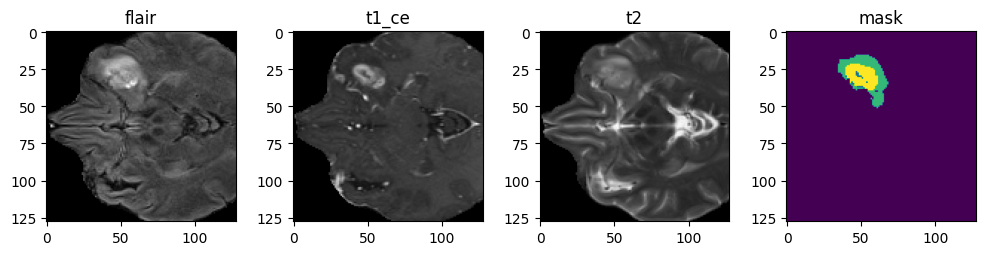

In [18]:
# verifying generator...
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(141)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('flair')
plt.subplot(142)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('t1_ce')
plt.subplot(143)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('t2')
plt.subplot(144)
plt.imshow(test_mask[:,:,n_slice])
plt.title('mask')

plt.subplots_adjust(wspace=0.3)
plt.show()

# 3D U-Net Model

In [6]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'

In [7]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          1,312 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128,  │              0 │ conv3d[0][0]           │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │          6,928 │ dropout[0][0]          │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 16) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64, 32) │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 32) │         27,680 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 32) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 32, 64) │              0 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32, 64) │        110,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 16, 16, 64) │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_2[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 16,     │              0 │ conv3d_6[0][0]         │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


# Train Model

In [8]:
import os
import numpy as np
import keras
from matplotlib import pyplot as plt
import glob
import random

In [9]:
train_img_dir = "/content/SPLIT/train/images"
train_mask_dir = "/content/SPLIT/train/masks"


img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(img_list)

img_num = random.randint(0, num_images - 1)

test_img = np.load(os.path.join(train_img_dir, img_list[img_num]))
test_mask = np.load(os.path.join(train_mask_dir, msk_list[img_num]))
test_mask = np.argmax(test_mask, axis=3)

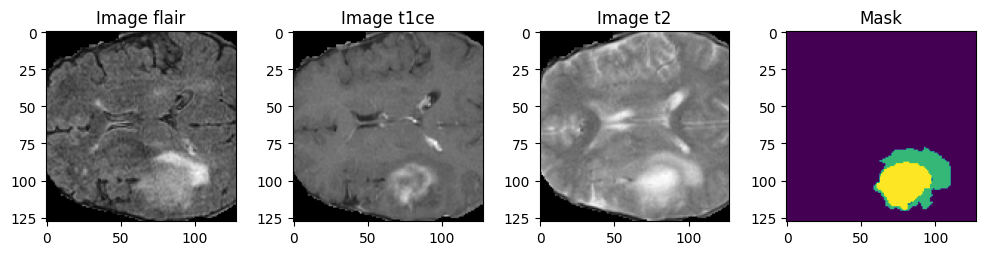

In [24]:
n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 3))

plt.subplot(141)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(142)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(143)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(144)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [10]:
# definin' the image generators for training and validation

train_img_dir = "/content/SPLIT/train/images"
train_mask_dir = "/content/SPLIT/train/masks"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_dir = "/content/SPLIT/val/images"
val_mask_dir = "/content/SPLIT/val/masks"

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

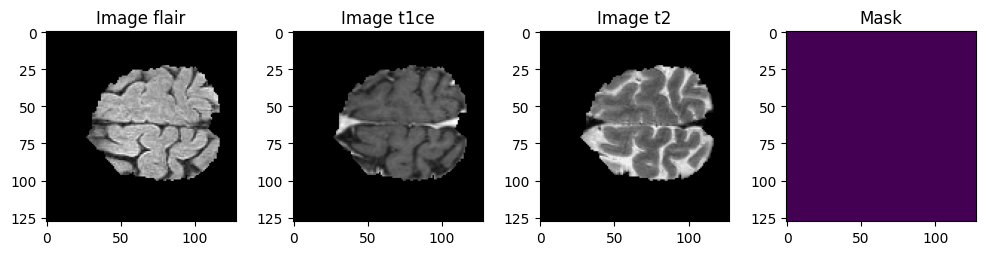

In [11]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 3))

plt.subplot(141)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(142)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(143)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(144)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [12]:
# !pip install segmentation_models
!pip install segmentation-models-3D

In [13]:
!pip install tensorflow

In [14]:
import segmentation_models_3D as sm
from tensorflow import keras

wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.001

Segmentation Models: using `keras` framework.


In [15]:
from keras.optimizers import Adam
optim = Adam()

In [16]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [33]:
from keras.callbacks import ModelCheckpoint

In [36]:
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          1,312 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128,  │              0 │ conv3d[0][0]           │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │          6,928 │ dropout[0][0]          │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 16) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64, 32) │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 32) │         27,680 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 32) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 32, 64) │              0 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32, 64) │        110,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 16, 16, 64) │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_2[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 16,     │              0 │ conv3d_6[0][0]         │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8671 - iou_score: 0.1930 - loss: 0.9623
Epoch 1: saving model to /content/models/model-01.keras

Epoch 1: val_loss improved from inf to 0.92074, saving model to /content/models/best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.8676 - iou_score: 0.1932 - loss: 0.9622 - val_accuracy: 0.9408 - val_iou_score: 0.3137 - val_loss: 0.9207
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9545 - iou_score: 0.3093 - loss: 0.9161
Epoch 2: saving model to /content/models/model-02.keras

Epoch 2: val_loss improved from 0.92074 to 0.91211, saving model to /content/models/best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.9544 - iou_score: 0.3092 - loss: 0.9161 - val_accuracy: 0.9447 - val_iou_score: 0.3512 - val_loss: 0.9121
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9559 - iou_score: 0.3563 - loss: 0.9064
Epoch 3: saving model to /content/models/model-03

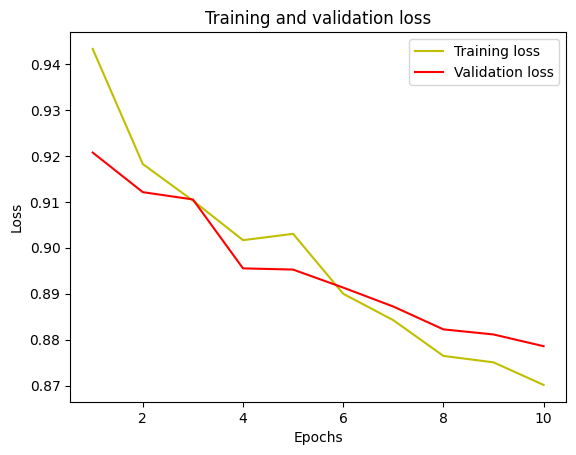

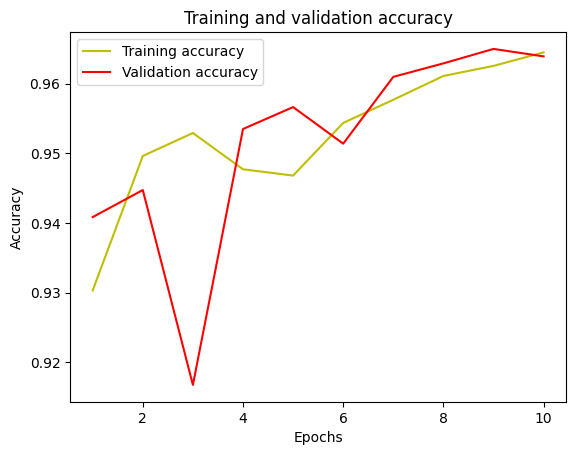

In [38]:
# ModelCheckpoint callbacks

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

checkpoint_path_periodic = "/content/models/model-{epoch:02d}.keras"
checkpoint_path_best = "/content/models/best_model.keras"

periodic_checkpoint = ModelCheckpoint(
    checkpoint_path_periodic,
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch'
)

best_checkpoint = ModelCheckpoint(
    checkpoint_path_best,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)

# for 10 epochs
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[periodic_checkpoint, best_checkpoint])


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss.png', dpi=400)
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_validation_accuracy.png', dpi=400)
plt.show()

# `Student Model`

In [17]:
!pip install segmentation-models-3D
from tensorflow.keras.models import load_model
from segmentation_models_3D.base.objects import SumOfLosses

custom_objects = {'SumOfLosses': SumOfLosses}

In [18]:
from segmentation_models_3D.metrics import IOUScore

def SumOfLosses_from_config(config):
    return SumOfLosses(config['config'])

def IOUScore_from_config(config):
    return IOUScore(**config)

custom_objects = {'SumOfLosses': SumOfLosses_from_config}
custom_objects['IOUScore'] = IOUScore_from_config

teacher_model = load_model('/content/models/best_model.keras', custom_objects=custom_objects)

In [19]:
def student_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    # Contraction path (fewer filters or layers compared to Teacher)
    c1 = Conv3D(8, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(s)
    c1 = Dropout(0.05)(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    # Middle (smaller depth)
    c3 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p2)
    c3 = Dropout(0.2)(c3)

    # Expansive path
    u4 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u4)
    c4 = Dropout(0.1)(c4)

    u5 = Conv3DTranspose(8, (2, 2, 2), strides=(2, 2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv3D(8, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u5)
    c5 = Dropout(0.05)(c5)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [21]:
import os
import numpy as np

def precompute_and_save_predictions(model, data_gen, steps_per_epoch, save_dir, batch_size, prefix):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for step in range(steps_per_epoch):
        imgs, masks = next(data_gen)

        pred = model.predict(imgs, batch_size=batch_size)
        np.save(os.path.join(save_dir, f"{prefix}_pred_batch_{step}.npy"), pred)

    print(f"Predictions saved to {save_dir}")

In [22]:
# save the precomputed teacher predictions
save_dir = "/content/teacher_preds"

precompute_and_save_predictions(teacher_model, train_img_datagen, steps_per_epoch, save_dir, batch_size, prefix='train')
precompute_and_save_predictions(teacher_model, val_img_datagen, val_steps_per_epoch, save_dir, batch_size, prefix='val')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predictions saved to /content/teacher_preds


In [27]:
import os
import numpy as np

def imageLoader_with_teacher_preds_from_disk(img_dir, img_list, mask_dir, mask_list, preds_dir, batch_size, prefix):
    L = len(img_list)
    step = 0
    num_batches = len([name for name in os.listdir(preds_dir) if name.startswith(prefix)])

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            # Load teacher's predictions, reset step if it exceeds the number of batches
            T = np.load(os.path.join(preds_dir, f"{prefix}_pred_batch_{step % num_batches}.npy"))

            yield (X, Y, T)

            batch_start += batch_size
            batch_end += batch_size
            step += 1

In [28]:
def distillation_loss(y_true, y_pred_student, teacher_preds, temperature, combined_loss):
    y_pred_teacher_soft = tf.nn.softmax(teacher_preds / temperature)
    y_pred_student_soft = tf.nn.softmax(y_pred_student / temperature)

    kl_loss = KLDivergence()(y_pred_teacher_soft, y_pred_student_soft)

    total_loss = 0.5 * kl_loss + 0.5 * combined_loss(y_true, y_pred_student)

    return total_loss


In [29]:
import segmentation_models_3D as sm

def combined_loss(y_true, y_pred):
    wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25
    dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
    focal_loss = sm.losses.CategoricalFocalLoss()
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)


In [30]:
import tensorflow as tf
import segmentation_models_3D as sm
from tensorflow.keras.losses import KLDivergence
import numpy as np

In [33]:
batch_size = 2
train_preds_dir = "/content/teacher_preds"
val_preds_dir = "/content/teacher_preds"

# use the modified generator that loads predictions from disk
train_img_datagen_with_preds = imageLoader_with_teacher_preds_from_disk(train_img_dir, train_img_list,
                                                                       train_mask_dir, train_mask_list,
                                                                       train_preds_dir, batch_size, prefix='train')

val_img_datagen_with_preds = imageLoader_with_teacher_preds_from_disk(val_img_dir, val_img_list,
                                                                     val_mask_dir, val_mask_list,
                                                                     val_preds_dir, batch_size, prefix='val')


In [ ]:
model.compile(optimizer=optim,
              loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred,
                                                                  next(train_img_datagen_with_preds)[2], # Access teacher predictions from generator using next()
                                                                  temperature=5.0,
                                                                  combined_loss=combined_loss))

# trainin' the student model
history_student = model.fit(train_img_datagen_with_preds,
                                steps_per_epoch=steps_per_epoch,
                                epochs=15,
                                validation_data=val_img_datagen_with_preds,
                                validation_steps=val_steps_per_epoch)

Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 684s 4s/step - loss: 0.1208 - val_loss: 0.1163
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - loss: 0.1161 - val_loss: 0.1155
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - loss: 0.1149 - val_loss: 0.1147
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - loss: 0.1136 - val_loss: 0.1144
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - loss: 0.1133 - val_loss: 0.1134
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - loss: 0.1122 - val_loss: 0.1119
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - loss: 0.1113 - val_loss: 0.1116
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - loss: 0.1107 - val_loss: 0.1124
Epoch 9/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - loss: 0.1102 - val_loss: 0.1108
Epoch 10/15
 34/128 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - loss: 0.1089

In [ ]:
# Plot and save the training and validation loss
loss = history_student.history['loss']
val_loss = history_student.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss.png', dpi=400)
plt.show()

# Plot and save the training and validation accuracy
acc = history_student.history['accuracy']
val_acc = history_student.history['val_accuracy']

plt.figure()
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_validation_accuracy.png', dpi=400)
plt.show()